# Baseline Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [4]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


In [5]:
# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

In [6]:
# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

## PCA

In [7]:
pca = PCA()
pca.fit(features)

PCA()

In [8]:
print(pca.explained_variance_ratio_)

[2.16655896e-01 1.89263230e-01 1.44454394e-01 1.01108304e-01
 8.02160439e-02 7.72166186e-02 6.34223648e-02 5.55345279e-02
 5.31560123e-02 1.89726089e-02 3.27893880e-29]


Here we can see, the first component explained 92.5% variance and the second component explained 5.3% variance. If we removed the first two principal components, the remaining variance is only 2.2%, hence visually the plot after removing two components looks like a straight line. In fact, when we check with the plots above, not only we see the points are crumbled, but the range in the x- and y-axes are also smaller as we removed the components.

Number of components explaining at least 80% variance: 6


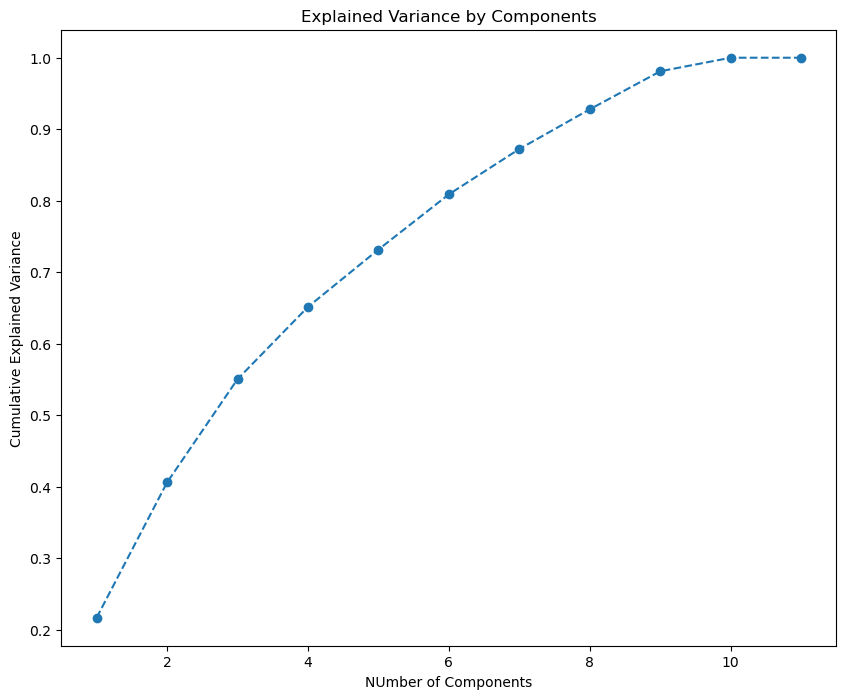

In [9]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize= (10, 8))
plt.plot(range(1,12), cumulative_explained_variance, marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components explaining at least 80% variance: {n_components_80}")

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 6 components.

In [10]:
pca = PCA(n_components=6)
features_pca = pca.fit_transform(features)

## Determine the number of clusters(k)

In [11]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


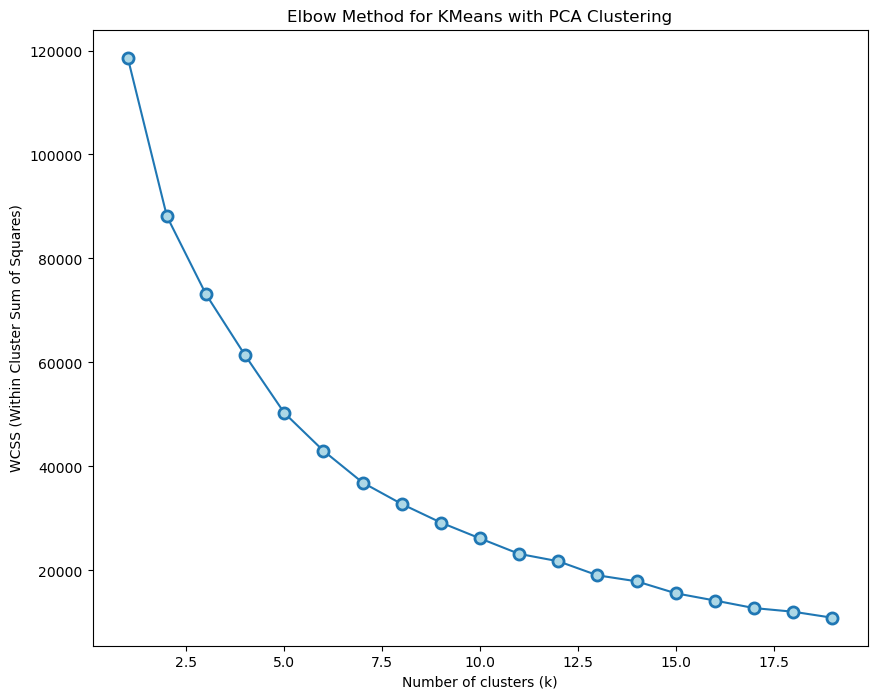

In [12]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans with PCA Clustering')
plt.show()

## Clustering

In [13]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=5, random_state=0).fit(features_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_pca)], axis=1)
df_pca.columns.values[-6: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6']
df_pca['clusters'] = kmeans.labels_
df_pca['cluster_kmeans'] = kmeans.predict(features_pca)
df_latex = df_pca.groupby(['cluster_kmeans']).mean()
df_latex

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,clusters
cluster_kmeans,,,,,,,,,,,,,,,,,,
0,0.544663,0.745834,0.492900,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.437531,0.376845,-0.506164,0.254363,-0.093462,0.721173,-0.305104,-0.082340,0.0
1,0.376806,0.705188,1.000000,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.332411,0.343063,0.762539,0.265066,0.110904,-0.044417,-0.102959,0.048882,1.0
2,0.694186,0.729839,0.453339,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.473773,0.419816,-0.565902,0.102946,0.149289,-0.612550,-0.255980,-0.463708,2.0
3,0.527923,0.803028,0.483561,0.277352,0.0,0.0,0.358245,0.0,0.364403,0.450841,0.402971,-0.367533,0.139256,-0.148618,-0.110692,0.377814,0.273572,3.0
4,0.436769,0.774892,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.563272,0.477326,0.401790,-0.688685,0.047412,0.054573,0.006303,-0.045101,4.0


In [14]:
df_latex.drop(columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'clusters'], inplace=True)
df_latex = df_latex.T

In [15]:
df_latex

cluster_kmeans,0,1,2,3,4
yeojohnson_revenue_in_eur_bin,0.544663,0.376806,0.694186,0.527923,0.436769
is_EMEA,0.745834,0.705188,0.729839,0.803028,0.774892
is_Webshop,0.492900,1.000000,0.453339,0.483561,0.000000
is_industry_FinanceInsuranceRealEstate,0.000000,0.000000,0.000000,0.277352,0.000000
is_industry_Manufacturing,0.000000,0.000000,1.000000,0.000000,0.000000
is_industry_Other,1.000000,0.000000,0.000000,0.000000,0.000000
is_industry_RetailTrade,0.000000,0.000000,0.000000,0.358245,0.000000
is_industry_Services,0.000000,1.000000,0.000000,0.000000,1.000000
is_industry_WholesaleTrade,0.000000,0.000000,0.000000,0.364403,0.000000
license_value_score,0.437531,0.332411,0.473773,0.450841,0.563272


In [16]:
latex_table = df_latex.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Average Values of each feature per Cluster",  # The caption to appear above the table in the LaTeX document
    label="tab:avg_clusters",  # A label used for referencing the table within the LaTeX document
    position="H",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="cccc",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.3f}".format  # Formats floats to two decimal places
)

print(latex_table)

\begin{table}[H]
\centering
\caption{Average Values of each feature per Cluster}
\label{tab:avg_clusters}
\begin{tabular}{cccc}
\toprule
    0 &     1 &     2 &     3 &     4 \\
\midrule
0.545 & 0.377 & 0.694 & 0.528 & 0.437 \\
0.746 & 0.705 & 0.730 & 0.803 & 0.775 \\
0.493 & 1.000 & 0.453 & 0.484 & 0.000 \\
0.000 & 0.000 & 0.000 & 0.277 & 0.000 \\
0.000 & 0.000 & 1.000 & 0.000 & 0.000 \\
1.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
0.000 & 0.000 & 0.000 & 0.358 & 0.000 \\
0.000 & 1.000 & 0.000 & 0.000 & 1.000 \\
0.000 & 0.000 & 0.000 & 0.364 & 0.000 \\
0.438 & 0.332 & 0.474 & 0.451 & 0.563 \\
0.377 & 0.343 & 0.420 & 0.403 & 0.477 \\
\bottomrule
\end{tabular}
\end{table}



In [17]:
df_pca.cluster_kmeans.value_counts()

3    27283
1    22014
4    21714
0    15423
2    13566
Name: cluster_kmeans, dtype: int64

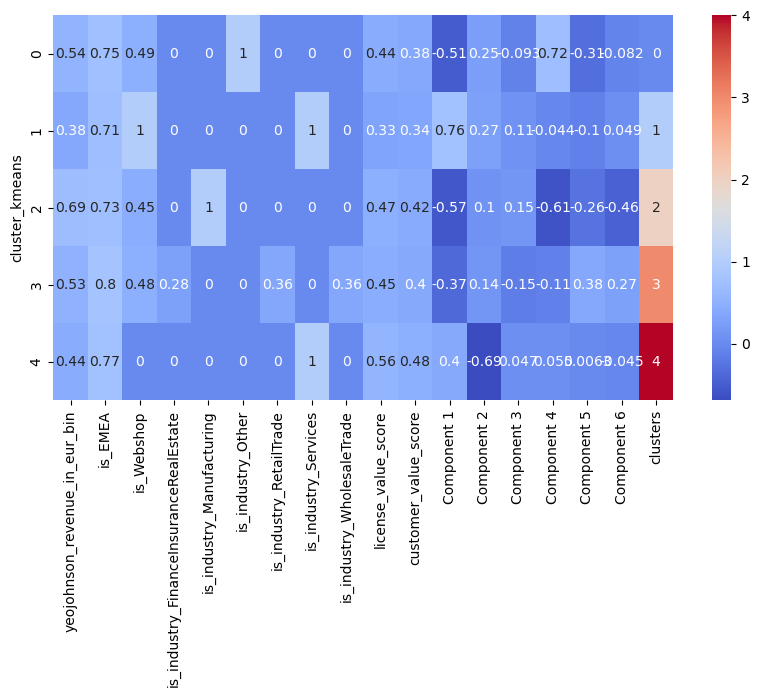

In [18]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_pca.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [19]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", 
                    line_close=True,
                    height=800,
                    width=1200, 
                    title="Baseline Model 10-Feature Set Radar Chart")
fig.show()

In [20]:
clusters_df = clusters.groupby('label').size().reset_index()
clusters_df.rename(columns={'label': 'cluster', 0: 'count'}, inplace=True)
clusters_df

,cluster,count
0,0,15423
1,1,22014
2,2,13566
3,3,27283
4,4,21714


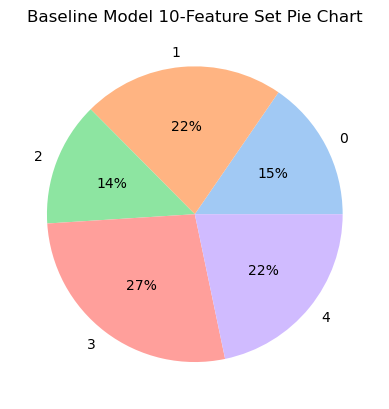

In [21]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(clusters_df['count'], labels = clusters_df['cluster'], colors = colors, autopct='%.0f%%')
plt.title('Baseline Model 10-Feature Set Pie Chart')
plt.show()

## Evaluation

In [22]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.281


In [23]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 1.593
